In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
#from scipy.optimize import fsolve
#from scipy.optimize import minimize
from scipy.optimize import curve_fit
import scipy.stats

from root_to_np import get_tree, get_df, rename_tree_branches

Welcome to JupyROOT 6.26/04
END OF SCRIPT


In [2]:
run = [630,636]
pad_name = [37,38,27,28]
which_mcp = [1,1,2,2]
#centers
centers_from_fit = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/pad_centers.txt',
                delimiter=" ", unpack=False)
#cross point
cross = [22.39996479308732, 25.69888050613195]
#cable delay
cable_delay = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/cable_delay.txt')
#cable_delay = cable_delay-np.array([7.,7.,6.,7.]) #630, 636 for central

# scale factors
p2 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(0))
p3 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(1))
#p2 = np.ones(4)
#p3 = np.zeros(4)
#get parametrization for slew
slew_par = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/slew_fit.txt')

# parametrization for resolution
#res_par = np.array([-0.32849046,  5.07849407, -0.08403142,  4.27988861, 14.19658886]) #627, 632
res_par = np.array([-0.28676373,  5.11823145, -0.0807887,   4.08463765, 15.16298117]) #630, 636


In [3]:
#load data
data = []
for irun in run:
    tree = get_tree(irun)
    
    var_indexes = np.array([1,2,4,5,6,7])
    for index in range(4):
        var_indexes = np.append(var_indexes,[index*10+8,index*10+9,index*10+12,index*10+14,index*10+11]) 
    var_indexes = np.append(var_indexes,[67,65,66])
    
    data_single = get_df(tree,*var_indexes)
    
    old_names = ['mcp_gpeak','mcp_qall','mcp_t']
    new_names = ['mcp1_gpeak','mcp1_qall','mcp1_t']
    names = [old_names,new_names]
    data_single = rename_tree_branches(data_single,*names)
    
    print(len(data_single))
    data.append(data_single)

data = pd.concat(data)
print(data.head())
print(len(data))

['Pico;1']
['srs', 'mcp_gpeak', 'mcp_qall', 'mcp_tnaive', 'mcp_t', 'mcp2_gpeak', 'mcp2_qall', 'mcp2_t', 'mm1_gpeak', 'mm1_qall', 'mm1_tnaive', 'mm1_t', 'mm1_qe', 'mm1_pl3', 'mm1_qfit', 'mm1_xh', 'mm1_qh', 'mm1_gmin', 'mm2_gpeak', 'mm2_qall', 'mm2_tnaive', 'mm2_t', 'mm2_qe', 'mm2_pl3', 'mm2_qfit', 'mm2_xh', 'mm2_qh', 'mm2_gmin', 'mm3_gpeak', 'mm3_qall', 'mm3_tnaive', 'mm3_t', 'mm3_qe', 'mm3_pl3', 'mm3_qfit', 'mm3_xh', 'mm3_qh', 'mm3_gmin', 'mm4_gpeak', 'mm4_qall', 'mm4_tnaive', 'mm4_t', 'mm4_qe', 'mm4_pl3', 'mm4_qfit', 'mm4_xh', 'mm4_qh', 'mm4_gmin', 'nmm1_x', 'mm1_x', 'nmm1_y', 'mm1_y', 'nmm2_x', 'mm2_x', 'nmm2_y', 'mm2_y', 'nmm3_x', 'mm3_x', 'nmm3_y', 'mm3_y', 'nmm4_x', 'mm4_x', 'nmm4_y', 'mm4_y', 'ntracks', 'xy', 'chi2', 'track_flag', 'ndetsintrack', 'distnextcluster']
<Report start=0 stop=4538 source='/home/evridiki/Downloads/test_run630.root:/Pico;1'>
<Report start=4538 stop=9076 source='/home/evridiki/Downloads/test_run630.root:/Pico;1'>
<Report start=9076 stop=13614 source='/home

<Report start=163404 stop=167943 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=167943 stop=172482 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=172482 stop=177021 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=177021 stop=181560 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=181560 stop=186099 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=186099 stop=190638 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=190638 stop=195177 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
<Report start=195177 stop=199350 source='/home/evridiki/Downloads/test_run636.root:/Pico;1'>
199350
   mcp1_gpeak  mcp1_qall      mcp1_t  mcp2_gpeak  mcp2_qall      mcp2_t  \
0    0.313779   3.629249  200.261986    0.329183   3.801939  197.282873   
1    0.407590   4.733348  201.549047    0.424461   4.972193  198.437085   
2    0.334093   3.823908

In [4]:
#define the cuts
mm_basic_cut= []

mcp_overflow = np.logical_and((data.mcp1_gpeak>0.3)*(data.mcp1_gpeak<=0.74),
                             (data.mcp2_gpeak>0.3)*(data.mcp2_gpeak<=0.74))
chi2_cut = (data.chi2<=40)*(data.track_flag>0)
mcp_basic_cut = mcp_overflow*chi2_cut

for index in range(4):
    pad = index+1
       
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_qe = f'mm{pad}_qe'
    mm_qfit = f'mm{pad}_qfit'
    mm_overflow = (data[mm_gpeak]>0.01)*(data[mm_gpeak]<0.36)*(data[mm_qall]>0)
    qe_line = (data[mm_qe]>30.*data[mm_gpeak])
    cut = np.logical_and(mm_overflow*mcp_basic_cut,qe_line)
    
    mm_basic_cut.append(cut)

In [5]:
def double_gaus( x, *params ):
    (c1, mu, sigma1, c2, sigma2) = params
    res =   c1 * np.exp( - (x - mu)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu)**2.0 / (2.0 * sigma2**2.0) )
    return res
def simple_gaus(x,c,mu,sigma):
    res =   c * np.exp( - (x - mu)**2.0 / (2.0 * sigma**2.0) ) 
    return res
def double_sigma(x, *params):
    prob =  double_gaus(x,*params)/double_gaus(x,*params).sum()
    mu_double   = x.dot(prob)         # mean value
    mom2 = np.power(x, 2).dot(prob)  # 2nd moment
    var  = mom2 - mu_double**2        # variance
    sigma = np.sqrt(var) 
    return sigma

def double_expo(x,*p):
    return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]

In [6]:
class SAT:
    def __init__(self, sat):
        self.sat = sat
    
    def GetAvrg(self,weights):
        avrg = np.average(self.sat,weights = weights)
        return avrg
    
    def GetWeightedStd(self,weights):
        variance = np.average((self.sat-self.GetAvrg(weights))**2, weights=weights)
        return np.sqrt(variance)
    
    def ReduceSAT(self,around=0, t_range=100):
        self.sat = self.sat[np.abs(self.sat- around)<= t_range] 
        
    def GetHist(self,bins=100):
        counts, edges = np.histogram(self.sat, bins =bins)
        bin_centers = (edges[1:]+edges[:-1])/2
        return counts, edges, bin_centers
        
    def PlotSAT(self,ax=plt, color='black',bins=100,label=''):
        c,_,b = self.GetHist(bins =bins)
        ax.errorbar(b, c, yerr=np.sqrt(c), fmt='o',markersize=4.,
                color=color,label= label)
        
    def PlotHist(self,ax=plt ,color='black',bins=100,label='',range=[]):
        if len(range)==0:
            range=[self.sat.min(),self.sat.max()]
        ax.hist(self.sat, bins =bins, range=range,
                            color = color, histtype='step',label = label)
        
    def FitSAT(self, f , p0,bins=100, param_bounds=([0.1,-np.inf,1,0.1,1],[np.inf,np.inf,np.inf,np.inf,np.inf])):
        if len(p0) != len(param_bounds[0]):
            print('ERROR!!! Check compatibility between parameters and their bounds')
            sys.exit(1)
            
        c,_,b = self.GetHist(bins =bins)
        popt, pcov = curve_fit(f, b, c, p0=p0, bounds = param_bounds)
        return popt

In [7]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

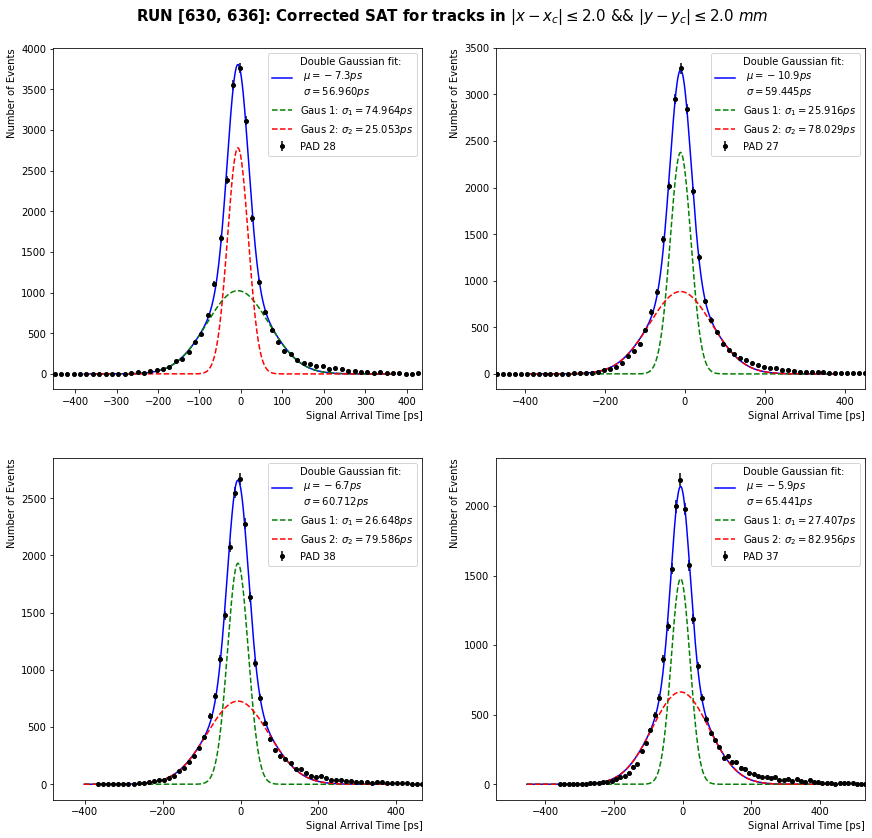

In [30]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)

radius = 2.

fig.suptitle(f'RUN {run}: Corrected SAT for tracks in $|x-x_c|\leq {radius}\ &&\ |y-y_c|\leq {radius}\ mm$',
             fontsize=15, fontweight='bold')

for index in range(4):
    pad=index+1
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_t = f'mm{pad}_t'
    mcp_t=f'mcp{which_mcp[index]}_t'
    
#     xc = centers_from_fit[0][index]
#     yc = centers_from_fit[1][index]
    xc = cross[0]
    yc = cross[1]
    
    square_cut = np.logical_and(np.abs(data.iloc[:,-4]-xc)<radius, np.abs(data.iloc[:,-3]-yc)<radius)
    mm_time_cut = mm_basic_cut[index]*(data[mm_gpeak]>0.02)*square_cut

    cable =cable_delay[index]-10
    q_scale = p2[index]*data[mm_qall][mm_time_cut]+p3[index]
    cor = double_expo(q_scale, *slew_par)
    sat = ((data[mm_t][mm_time_cut] - data[mcp_t][mm_time_cut])*1000 -cable) - cor #ps
    
    sat_hist = SAT(sat)
    w = np.abs(1/sat_hist.sat)
    avrg,std = sat_hist.GetAvrg(w), sat_hist.GetWeightedStd(w)
    
    sat_hist.ReduceSAT(avrg,50*std) # to exclude times waaay out of range
    #and update
    avrg,std = sat_hist.sat.mean(), sat_hist.sat.std()
    
    g2_par = np.array([350.,0.,10,50,30])
    g2_par =sat_hist.FitSAT(f = double_gaus,p0=g2_par)
    (c1, mu, sigma1, c2, sigma2) = g2_par
    
    plt.subplot(2, 2, 4-index )
    sat_hist.PlotSAT(label=f'PAD {pad_name[index]}')
    x = np.linspace(mu-5*std,mu+5*std,2000)
    sigma_double = double_sigma(x,*g2_par)
    
    plt.plot(x,double_gaus(x,*g2_par),color='blue',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(g2_par[1],sigma_double))

    plt.plot(x,simple_gaus(x,c1,mu,sigma1),'g--',
         label=f'Gaus 1: $\sigma_1 = {sigma1:.3f} ps$')
    plt.plot(x,simple_gaus(x,c2,mu,sigma2),'r--', 
         label =f'Gaus 2: $\sigma_2 = {sigma2:.3f} ps$' )
    
    plt.xlabel('Signal Arrival Time [ps]',loc='right')
    plt.ylabel('Number of Events',loc='top')
    plt.legend(loc='upper right')
    plt.xlim(mu-6*std,mu+6*std)
    
plt.show()

In [9]:
xc = cross[0]#+9.82/4
yc = cross[1]#-9.82/3
radius = 2.

In [10]:
subdata=[None]*4
square_cut = np.logical_and(np.abs(data.iloc[:,-4]-xc)<radius, np.abs(data.iloc[:,-3]-yc)<radius)

for index in [0,1,2,3]:
    pad=index+1
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_t = f'mm{pad}_t'
    mcp_t=f'mcp{which_mcp[index]}_t'
    mm_overflow = (data[mm_qall]>0.5)*(data[mm_gpeak]<0.36)

    mm_basic_cut[index] = np.logical_and(mm_overflow,mcp_basic_cut)
    mm_time_cut = mm_basic_cut[index]*square_cut
    
    subdata[index]=data[mm_time_cut]

comondata = subdata[0].merge(subdata[1], how = 'inner' ,indicator=False)
comondata = comondata.merge(subdata[2], how = 'inner' ,indicator=False)
comondata = comondata.merge(subdata[3], how = 'inner' ,indicator=False)

print(len(comondata)) #all pads not overflowing

23817


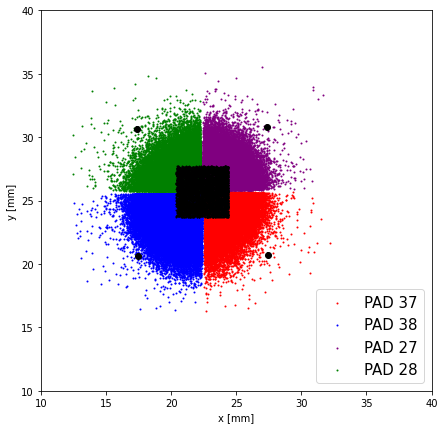

In [11]:
fig, ax = plt.subplots(figsize=(7,7))
color = np.array(['red','blue','purple','green'])

for i,xy in enumerate(centers_from_fit.T):
    mm_gpeak = f'mm{pad}_gpeak'
    
    square = np.logical_and(np.abs(data.iloc[:,-4]-xy[0])<=4.91,
                            np.abs(data.iloc[:,-3]-xy[1])<=4.91)

    mm_cut = np.logical_and(mm_basic_cut[i]*data[mm_gpeak]>0.01,square)
    
    x = data[mm_cut].iloc[:,-4].values
    y = data[mm_cut].iloc[:,-3].values
    ax.scatter(x,y,color = color[i],
             label =f'PAD {pad_name[i]}',s=1)
    ax.errorbar(xy[0],xy[1],yerr =0.2 ,xerr=0.15,color = 'black',
             fmt='o',markersize=6.)
    

x = data[square_cut].iloc[:int(0.5e04),-4].values
y = data[square_cut].iloc[:int(0.5e04),-3].values
ax.scatter(x,y,color = 'black',s=1)
ax.set_xlim(10,40)
ax.set_ylim(10,40)
ax.legend(prop={'size': 15})
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
plt.show()

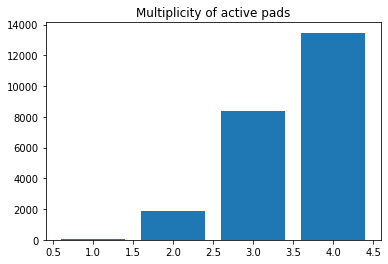

In [12]:
#pads activity
active_sum = np.zeros(len(comondata),dtype=int)
q_active = 2. # to be considered active
for index in range(4):
    active_condition = (p2[index]*comondata[f'mm{index+1}_qall']+p3[index])>q_active
    active_sum = active_sum + active_condition*1

plt.bar([1,2,3,4],[len(active_sum[active_sum==1]),len(active_sum[active_sum==2]),
                   len(active_sum[active_sum==3]),len(active_sum[active_sum==4])])
plt.title('Multiplicity of active pads')
plt.show()

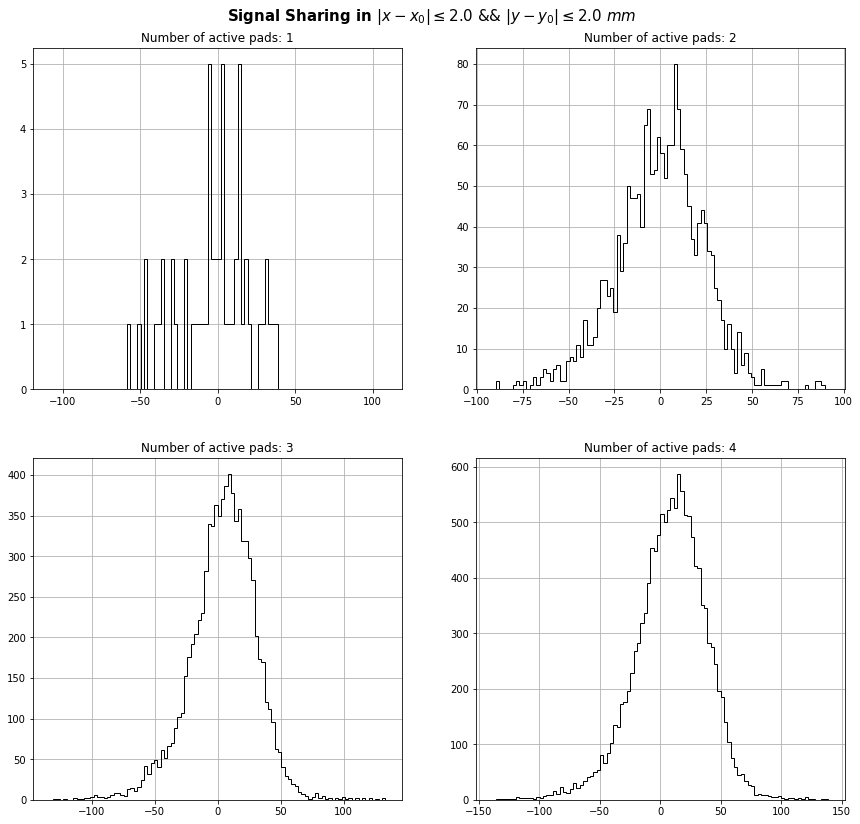

In [13]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'Signal Sharing in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')
Tcombined = [None]*4

for active_pads in [1,2,3,4]:

    sum_nom=np.zeros(len(active_sum[active_sum==active_pads]))
    sum_denom=np.zeros(len(active_sum[active_sum==active_pads]))

    for index in range(4):
        pad=index+1
        mm_qall = f'mm{pad}_qall'
        mm_t = f'mm{pad}_t'
        mcp_t=f'mcp{which_mcp[index]}_t'
    
        cable =cable_delay[index]-10
        q_scale = p2[index]*comondata[active_sum==active_pads][mm_qall]+p3[index]
        cor = double_expo(q_scale, *slew_par)
        sat = ((comondata[active_sum==active_pads][mm_t]- \
                comondata[active_sum==active_pads][mcp_t])*1000-cable)-cor #ps
    
        resol = double_expo(q_scale, *res_par)
    
        active_condition =q_scale>q_active
    
        sum_nom = sum_nom + active_condition*sat/resol**2
        sum_denom = sum_denom +active_condition*1/resol**2
    
    t_comb = sum_nom/sum_denom  
    Tcombined[active_pads-1]=SAT(t_comb)
    
    plt.subplot(2, 2, active_pads)
    if len(Tcombined[active_pads-1].sat)<5:
        continue
    
    w = 1/np.abs(t_comb)
    avrg, std = Tcombined[active_pads-1].GetAvrg(w), Tcombined[active_pads-1].GetWeightedStd(w)
    
    Tcombined[active_pads-1].PlotHist(range=[-10*std,10*std])
    plt.grid()
    plt.title(f'Number of active pads: {active_pads}')

plt.show()

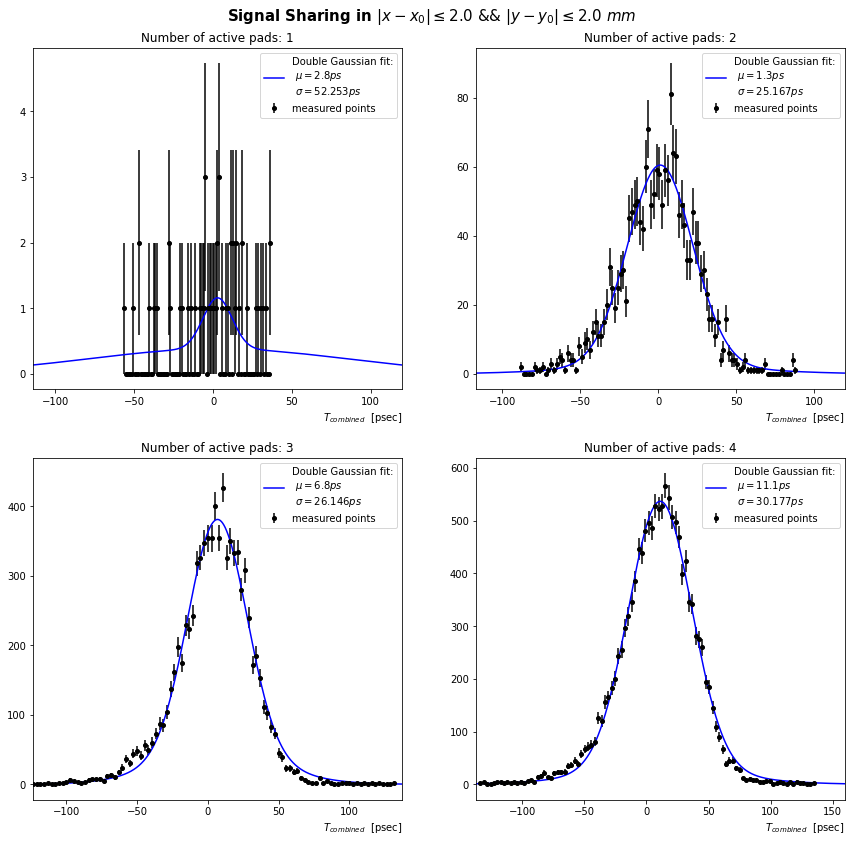

In [14]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'Signal Sharing in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')

for active_pads in [1,2,3,4]:
    index = active_pads-1
    
    plt.subplot(2, 2, active_pads)
    if len(Tcombined[index].sat)<5:
        continue
    
    w = np.abs(1/Tcombined[index].sat)
    avrg,std = Tcombined[index].GetAvrg(w), Tcombined[index].GetWeightedStd(w)
    
    Tcombined[index].ReduceSAT(avrg,10*std) # to exclude times waaay out of range
    #and update
    avrg,std = Tcombined[index].sat.mean(), Tcombined[index].sat.std()
    
    c,_,_ = Tcombined[index].GetHist()
    g2_par = np.array([c.max(),0.,10,c.max()/3,30])
    g2_par =Tcombined[index].FitSAT(f = double_gaus,p0=g2_par)
    g2_par =Tcombined[index].FitSAT(f = double_gaus,p0=g2_par)
    (c1, mu, sigma1, c2, sigma2) = g2_par
    
    Tcombined[index].PlotSAT(label='measured points')
    x = np.linspace(mu-5*std,mu+5*std,2000)
    sigma_double = double_sigma(x,*g2_par)
    
    plt.plot(x,double_gaus(x,*g2_par),color='blue',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(mu,sigma_double))
    plt.legend(loc='upper right')
    plt.title(f'Number of active pads: {active_pads}')
    plt.xlabel(r'$T_{combined}$  [psec]',loc='right')
    plt.xlim(mu-5*std,mu+5*std)

plt.show()

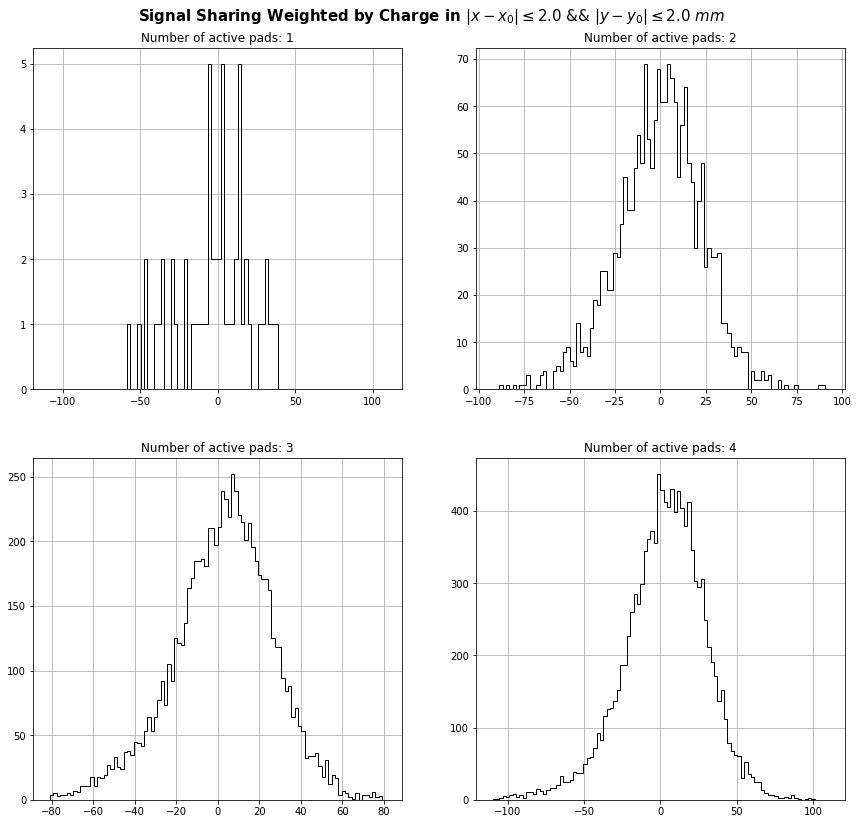

In [15]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'Signal Sharing Weighted by Charge in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')

Tcombined_Q=[None]*4
for active_pads in [1,2,3,4]:

    sum_nom=np.zeros(len(active_sum[active_sum==active_pads]))
    sum_denom=np.zeros(len(active_sum[active_sum==active_pads]))
    sum_q = np.zeros(len(active_sum[active_sum==active_pads]))

    for index in range(4):
        pad=index+1
        mm_qall = f'mm{pad}_qall'
        mm_t = f'mm{pad}_t'
        mcp_t=f'mcp{which_mcp[index]}_t'
    
        cable =cable_delay[index]-10
        q_scale = p2[index]*comondata[active_sum==active_pads][mm_qall]+p3[index]
        cor = double_expo(q_scale, *slew_par)
        sat = ((comondata[active_sum==active_pads][mm_t]- \
                comondata[active_sum==active_pads][mcp_t])*1000-cable)-cor #ps
    
        resol = double_expo(q_scale, *res_par)
    
        active_condition = q_scale>q_active
    
        sum_nom = sum_nom + active_condition*(q_scale)*sat/(resol**2)
        sum_denom = sum_denom +active_condition*(q_scale)/(resol**2)
        sum_q = sum_q +active_condition*q_scale
    
    t_comb = (sum_nom/sum_q)/(sum_denom/sum_q)
    Tcombined_Q[active_pads-1]=SAT(t_comb[sum_q<65.])
    
    plt.subplot(2, 2, active_pads)
    if len(Tcombined_Q[active_pads-1].sat)<5:
        continue
        
    w = 1/np.abs( Tcombined_Q[active_pads-1].sat )
    avrg, std = Tcombined_Q[active_pads-1].GetAvrg(w), Tcombined_Q[active_pads-1].GetWeightedStd(w)
    #print(avrg, std)
                                
    Tcombined_Q[active_pads-1].PlotHist(range=[-10*std,10*std])
    plt.grid()
    plt.title(f'Number of active pads: {active_pads}')

plt.show()

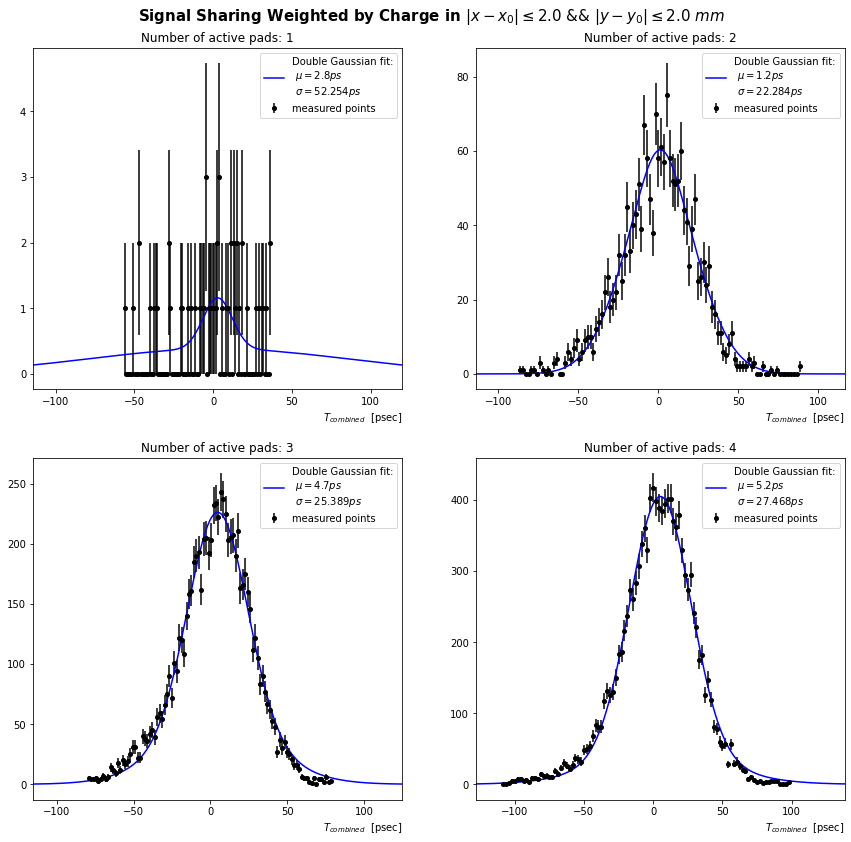

In [16]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'Signal Sharing Weighted by Charge in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')

for active_pads in [1,2,3,4]:
    index = active_pads-1
    
    plt.subplot(2, 2, active_pads)
    if len(Tcombined[active_pads-1].sat)<5:
        continue
    
    w = np.abs(1/Tcombined_Q[index].sat)
    avrg,std = Tcombined_Q[index].GetAvrg(w), Tcombined_Q[index].GetWeightedStd(w)
    
    Tcombined_Q[index].ReduceSAT(avrg,10*std) # to exclude times waaay out of range
    #and update
    avrg,std = Tcombined_Q[index].sat.mean(), Tcombined_Q[index].sat.std()
    
    c,_,_ = Tcombined_Q[index].GetHist()
    g2_par = np.array([c.max(),0.,10,c.max()/3,30])
    g2_par =Tcombined_Q[index].FitSAT(f = double_gaus,p0=g2_par)
    (c1, mu, sigma1, c2, sigma2) = g2_par
    
    Tcombined_Q[index].PlotSAT(label='measured points')
    x = np.linspace(mu-5*std,mu+5*std,2000)
    sigma_double = double_sigma(x,*g2_par)
    
    plt.plot(x,double_gaus(x,*g2_par),color='blue',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(mu,sigma_double))
    plt.legend(loc='upper right')
    plt.title(f'Number of active pads: {active_pads}')
    plt.xlabel(r'$T_{combined}$  [psec]',loc='right')
    plt.xlim(mu-5*std,mu+5*std)

plt.show()

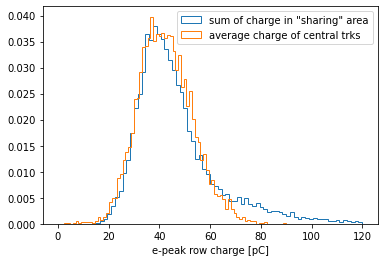

In [17]:
plt.hist(sum_q,bins=80,histtype='step',density=True,range=[0,120],label='sum of charge in "sharing" area')

all_pads_q = []
for index in range(4):
    pad = index+1
       
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_qe = f'mm{pad}_qe'
    mm_qfit = f'mm{pad}_qfit'
    mm_overflow = (data[mm_gpeak]>0.01)*(data[mm_gpeak]<0.36)*(data[mm_qall]>0)
    qe_line = (data[mm_qe]>30.*data[mm_gpeak])
    mm_basic_cut[index] = np.logical_and(mm_overflow*mcp_basic_cut,qe_line)
    
    xc1 = centers_from_fit[0][index]
    yc1 = centers_from_fit[1][index]
    square_cut1 = np.logical_and(np.abs(data.iloc[:,-4]-xc1)<radius, np.abs(data.iloc[:,-3]-yc1)<radius)
    mm_time_cut = mm_basic_cut[index]*square_cut1
    
    all_pads_q.append(p2[index]*data[mm_time_cut][mm_qall]+p3[index])
    

all_pads_q = pd.concat(all_pads_q)
plt.hist(all_pads_q,bins=80,histtype='step',density=True,label='average charge of central trks')

plt.legend()
plt.xlabel('e-peak row charge [pC]')
plt.show()

In [18]:
t_all = Tcombined[0].sat
t_all= np.concatenate((Tcombined[1].sat,Tcombined[2].sat,Tcombined[3].sat))
T = SAT(t_all)

t_all = Tcombined_Q[0].sat
t_all= np.concatenate((Tcombined_Q[1].sat,Tcombined_Q[2].sat,Tcombined_Q[3].sat))
T_Q = SAT(t_all)


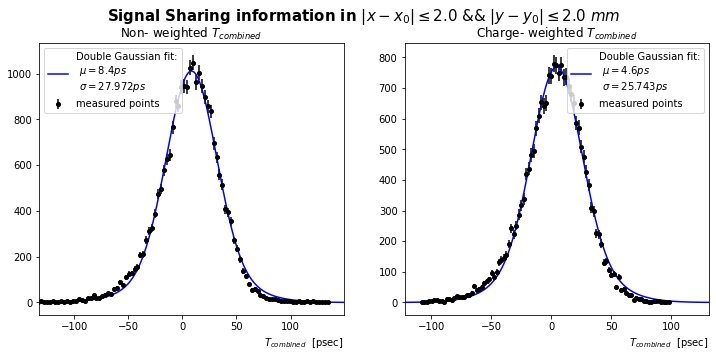

In [19]:
fig,axes = plt.subplots(1,2,figsize=(12,5))
fig.suptitle(f'Signal Sharing information in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')

avrg,std = T.sat.mean(), T.sat.std()
    
c,_,_ = T.GetHist()
g2_par = np.array([c.max(),0.,10,c.max()/4,30])
g2_par =T.FitSAT(f = double_gaus,p0=g2_par)
g2_par =T.FitSAT(f = double_gaus,p0=g2_par)
(c1, mu, sigma1, c2, sigma2) = g2_par

ax = axes[0]

T.PlotSAT(ax=ax,label='measured points')
x = np.linspace(mu-5*std,mu+5*std,2000)
sigma_double = double_sigma(x,*g2_par)
    
ax.plot(x,double_gaus(x,*g2_par),color='blue',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(mu,sigma_double))
ax.legend(loc='upper right')
ax.set_title(r'Non- weighted $T_{combined}$')
ax.set_xlabel(r'$T_{combined}$  [psec]',loc='right')
ax.set_xlim(mu-5*std,mu+5*std)
ax.legend()

##############################
avrg,std = T_Q.sat.mean(), T_Q.sat.std()
    
c,_,_ = T_Q.GetHist()
g2_par = np.array([c.max(),0.,10,c.max()/4,15])
g2_par =T_Q.FitSAT(f = double_gaus,p0=g2_par)
g2_par =T_Q.FitSAT(f = double_gaus,p0=g2_par)
(c1, mu, sigma1, c2, sigma2) = g2_par

ax = axes[1]

T_Q.PlotSAT(ax=ax,label='measured points')
x = np.linspace(mu-5*std,mu+5*std,2000)
sigma_double = double_sigma(x,*g2_par)
    
ax.plot(x,double_gaus(x,*g2_par),color='blue',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(mu,sigma_double))
ax.legend(loc='upper right')
ax.set_title(r'Charge- weighted $T_{combined}$')
ax.set_xlabel(r'$T_{combined}$  [psec]',loc='right')
ax.set_xlim(mu-5*std,mu+5*std)
ax.legend()

plt.show()

## NEW TECHNIQUE

In [25]:
#p_ij matrix
dp = {
    (0,0): [3.697964e-02,-9.396288e00,-7.807549e-02,4.481868e00, -3.728448e00],
    (0,1): [3.039256e-01, 6.494117e00, -2.170923e00, 1.109912e01, 4.279521e01],
    (0,2): [-2.573752e-01, 6.0210669e00,-1.729851e00,9.571438e00, 3.557180e01],
    (0,3): [-2.618238e00, 1.147889e01,-4.264001e-01,6.919159e00, 7.615702e01],
    (1,0): [-2.238530e-01, 5.518716e00, -3.835525e-01, 6.102468e00, 4.230197e01],
    (1,1): [-1.067506e-01, 4.282504e00, -1.067151e-01, 3.9976202e00, 3.199242e-01],
    (1,2): [-4.816969e+01,-4.035193e+02,-4.843924e-01, 7.168667e00, 7.133537e+01],
    (1,3): [-6.043143e-02, 5.512084e00,-7.729233e-01,7.487218e00,-5.975185e+01],
    (2,0): [-3.825067e-01, 6.634574e+00,-2.807564e00, -9.184389e+00,5.507124e+01],
    (2,1): [-4.615878e-01,6.922857e+00,-3.618007e+00,1.375380e01,8.233650e+01],
    (2,2): [-1.430716e-01,5.089956e00,-1.830504e-03,4.812310e00,-1.136936e+02],
    (2,3): [-3.001605e-01, 6.488352e+00, -4.810624e+00, 1.810568e+01, 4.361666e+01],
    (3,0): [-5.429477e-01,7.413567e+00,-5.933885e+01,-5.784236e+00,8.549844e+01],
    (3,1): [-3.583880e-02,5.664846e+00,-5.446343e-01,6.717529e+00,-1.321077e+02],
    (3,2): [-2.321060e-01,6.202244e+00,-1.431618e+00,8.947397e+00, 3.547750e+01],
    (3,3): [-1.001270e-01,4.645599e+00,-2.622151e-01,-2.542396e+00, -6.402556e-01] 
}

#cable_delay = cable_delay+np.array([12.,13.,16.,13.]) #630, 636 for central

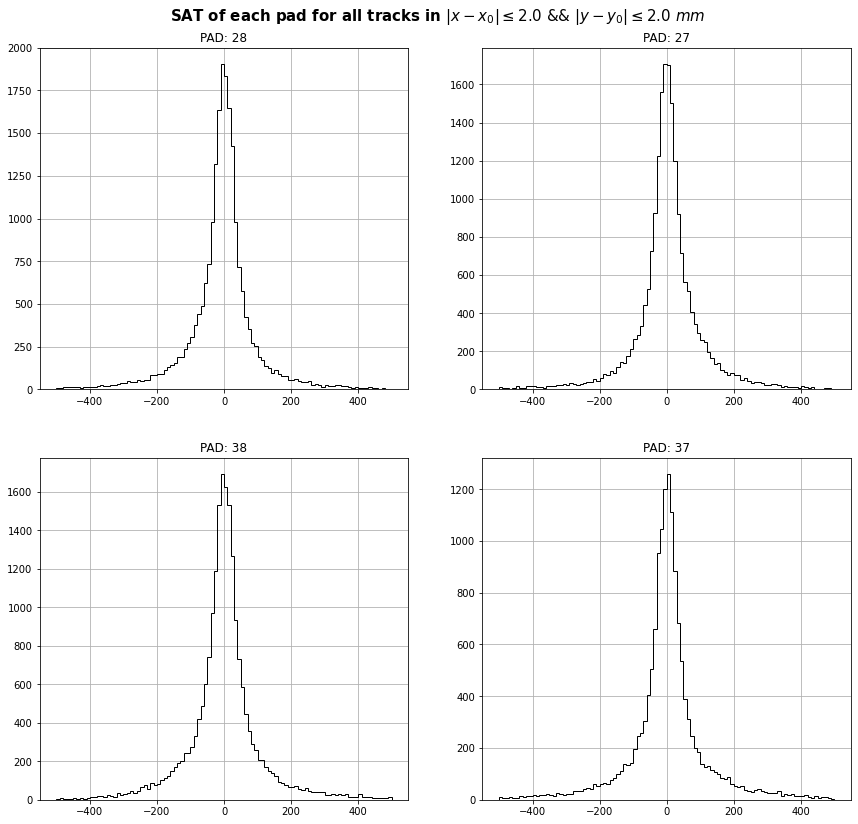

In [32]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'SAT of each pad for all tracks in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')
Tindiv_pads = [None]*4

for index in range(4):
        pad=index+1
        mm_qall = f'mm{pad}_qall'
        mm_t = f'mm{pad}_t'
        mcp_t=f'mcp{which_mcp[index]}_t'
        q_cut = comondata[mm_qall]>2.
    
        cable =cable_delay[index]
        q_scale = p2[index]*comondata[q_cut][mm_qall]+p3[index]
        ########
        # to find max charge: A ---> hit pad---> p0..p4 adgust
        A = comondata[q_cut][['mm1_qall','mm2_qall','mm3_qall','mm4_qall']].idxmax(axis=1)
        dp0 = [dp[( index,int(j[2])-1 )][0] for j in A]
        dp1 = [dp[( index,int(j[2])-1 )][1] for j in A]
        dp2 = [dp[( index,int(j[2])-1 )][2] for j in A]
        dp3 = [dp[( index,int(j[2])-1 )][3] for j in A]
        dp4 = [dp[( index,int(j[2])-1 )][4] for j in A]
        
        ij = pd.concat([q_scale,A],axis=1)
        ij['dp0'] = dp0
        ij['dp1'] = dp1
        ij['dp2'] = dp2
        ij['dp3'] = dp3
        ij['dp4'] = dp4

        ij['cor'] = np.exp(ij[mm_qall]*ij['dp0']+ij['dp1'])+np.exp(ij[mm_qall]*ij['dp2']+ij['dp3'])+ij['dp4']
        cor = ij['cor']
        ########
        sat = ((comondata[q_cut][mm_t]- \
                comondata[q_cut][mcp_t])*1000-cable)-cor #ps
    
        resol = double_expo(q_scale, *res_par)
        
         
        Tindiv_pads[index]=SAT(sat)
    
        w = np.abs(1/(Tindiv_pads[index].sat))
        avrg,std = Tindiv_pads[index].GetAvrg(w), Tindiv_pads[index].GetWeightedStd(w)
        Tindiv_pads[index].ReduceSAT(avrg,500) # to exclude times waaay out of range
            
        plt.subplot(2, 2, 4-index)
        if len(Tindiv_pads[index].sat)<5:
            continue
    
        w = 1/np.abs(Tindiv_pads[index].sat)
        avrg, std = Tindiv_pads[index].GetAvrg(w), Tindiv_pads[index].GetWeightedStd(w)
    
        Tindiv_pads[index].PlotHist(range=[-500,500])
        plt.grid()
        
        plt.title(f'PAD: {pad_name[index]}')

plt.show()

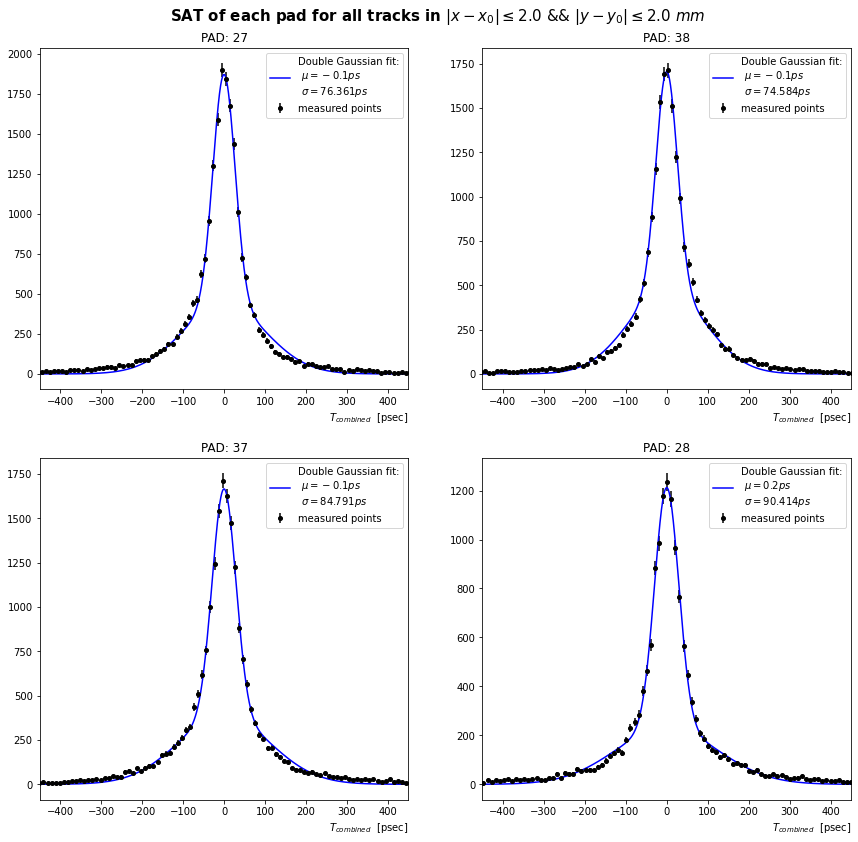

In [34]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'SAT of each pad for all tracks in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')

for index in [0,1,2,3]:
    
    plt.subplot(2, 2, 4-index)
    if len(Tindiv_pads[index].sat)<5:
        continue
    
    w = np.abs(1/Tindiv_pads[index].sat)
    avrg,std = Tindiv_pads[index].GetAvrg(w), Tindiv_pads[index].GetWeightedStd(w)
    std=450/5
    #Tindiv_pads[index].ReduceSAT(avrg,450) # to exclude times waaay out of range
    #and update
    #avrg,std = Tindiv_pads[index].sat.mean(), Tindiv_pads[index].sat.std()
    
    c,_,_ = Tindiv_pads[index].GetHist()
    g2_par = np.array([c.max(),0.,10,c.max()/3,30])
    g2_par =Tindiv_pads[index].FitSAT(f = double_gaus,p0=g2_par)
    g2_par =Tindiv_pads[index].FitSAT(f = double_gaus,p0=g2_par)
    (c1, mu, sigma1, c2, sigma2) = g2_par
    
    Tindiv_pads[index].PlotSAT(label='measured points')
    x = np.linspace(mu-5*std,mu+5*std,2000)
    sigma_double = double_sigma(x,*g2_par)
    
    plt.plot(x,double_gaus(x,*g2_par),color='blue',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(mu,sigma_double))
    plt.legend(loc='upper right')
    plt.title(f'PAD: {pad_name[index-1]}')
    plt.xlabel(r'$T_{combined}$  [psec]',loc='right')
    plt.xlim(mu-5*std,mu+5*std)

plt.show()

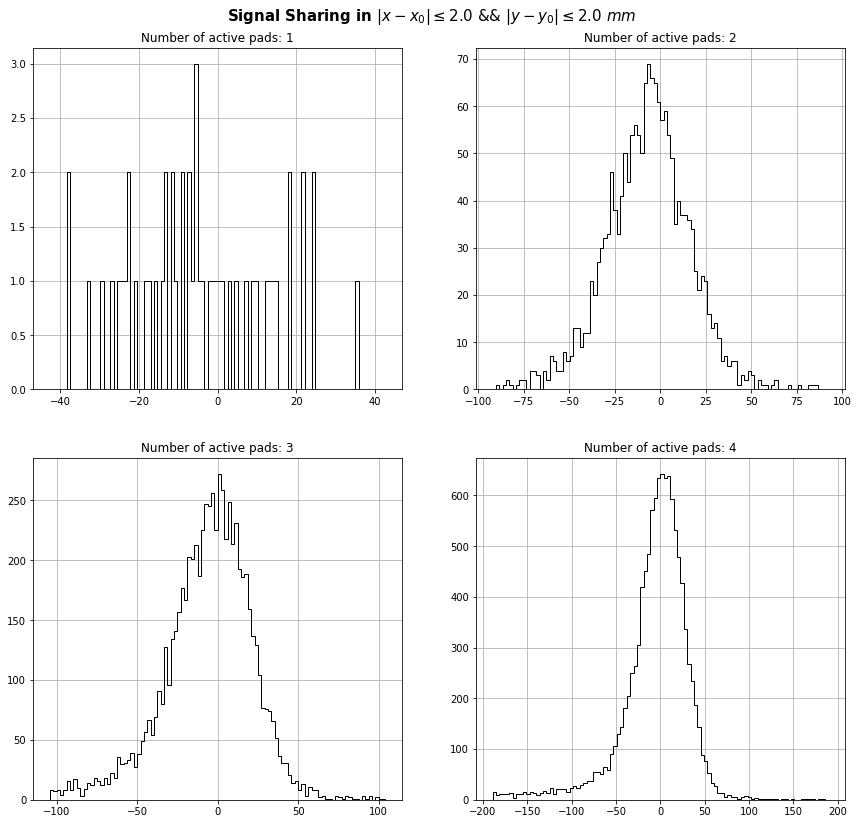

In [28]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'Signal Sharing in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')
Tcombined = [None]*4

for active_pads in [1,2,3,4]:

    sum_nom=np.zeros(len(active_sum[active_sum==active_pads]))
    sum_denom=np.zeros(len(active_sum[active_sum==active_pads]))

    for index in range(4):
        pad=index+1
        mm_qall = f'mm{pad}_qall'
        mm_t = f'mm{pad}_t'
        mcp_t=f'mcp{which_mcp[index]}_t'
    
        cable =cable_delay[index]
        q_scale = p2[index]*comondata[active_sum==active_pads][mm_qall]+p3[index]
        ########
        # to find max charge: A ---> hit pad---> p0..p4 adgust
        A = comondata[active_sum==active_pads][['mm1_qall','mm2_qall','mm3_qall','mm4_qall']].idxmax(axis=1)
        dp0 = [dp[( index,int(j[2])-1 )][0] for j in A]
        dp1 = [dp[( index,int(j[2])-1 )][1] for j in A]
        dp2 = [dp[( index,int(j[2])-1 )][2] for j in A]
        dp3 = [dp[( index,int(j[2])-1 )][3] for j in A]
        dp4 = [dp[( index,int(j[2])-1 )][4] for j in A]
        
        ij = pd.concat([q_scale,A],axis=1)
        ij['dp0'] = dp0
        ij['dp1'] = dp1
        ij['dp2'] = dp2
        ij['dp3'] = dp3
        ij['dp4'] = dp4

        ij['cor'] = np.exp(ij[mm_qall]*ij['dp0']+ij['dp1'])+np.exp(ij[mm_qall]*ij['dp2']+ij['dp3'])+ij['dp4']
        cor = ij['cor']
        ########
        sat = ((comondata[active_sum==active_pads][mm_t]- \
                comondata[active_sum==active_pads][mcp_t])*1000-cable)-cor #ps
    
        resol = double_expo(q_scale, *res_par)
    
        active_condition =q_scale>q_active
    
        sum_nom = sum_nom + active_condition*sat/resol**2
        sum_denom = sum_denom +active_condition*1/resol**2
    
    t_comb = sum_nom/sum_denom  
    Tcombined[active_pads-1]=SAT(t_comb)
    
    w = np.abs(1/(Tcombined[active_pads-1].sat))
    avrg,std = Tcombined[active_pads-1].GetAvrg(w), Tcombined[active_pads-1].GetWeightedStd(w)
    Tcombined[active_pads-1].ReduceSAT(avrg,10*std) # to exclude times waaay out of range
    #and update
    avrg,std = Tcombined[active_pads-1].sat.mean(), Tcombined[active_pads-1].sat.std()
    
    plt.subplot(2, 2, active_pads)
    if len(Tcombined[active_pads-1].sat)<5:
        continue
    
    w = 1/np.abs(Tcombined[active_pads-1].sat)
    avrg, std = Tcombined[active_pads-1].GetAvrg(w), Tcombined[active_pads-1].GetWeightedStd(w)
    
    Tcombined[active_pads-1].PlotHist(range=[-5*std,5*std])
    plt.grid()
    plt.title(f'Number of active pads: {active_pads}')

plt.show()

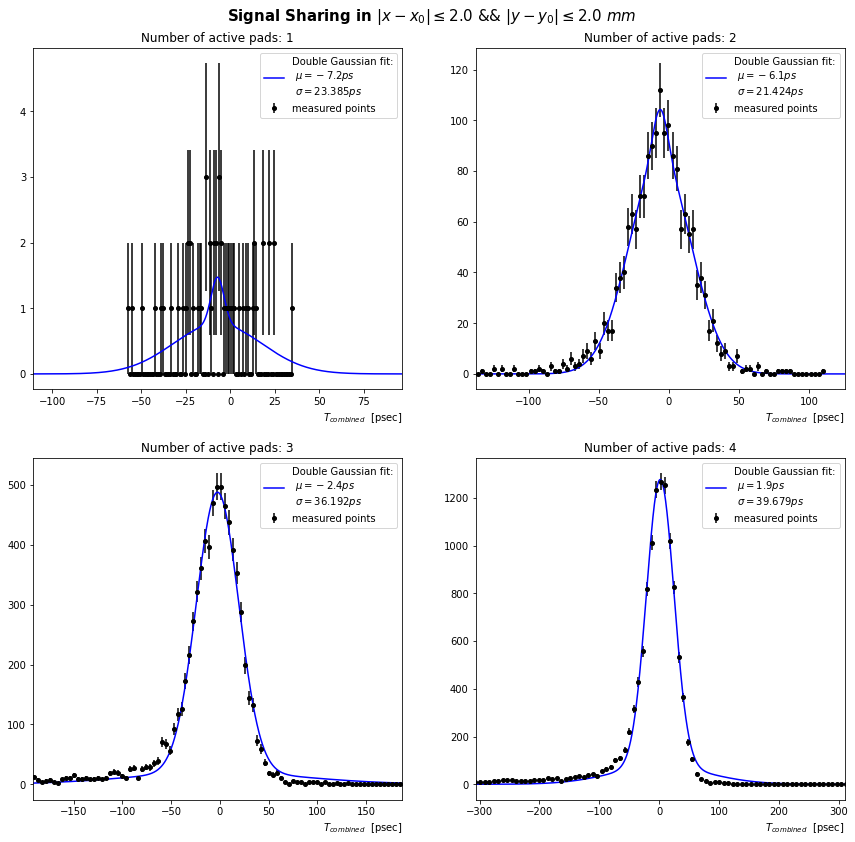

In [29]:
fig,axes = plt.subplots(figsize=(12,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'Signal Sharing in $|x-x_0|\leq {radius}\ &&\ |y-y_0|\leq {radius}\ mm$', 
             fontsize=15, fontweight='bold')

for active_pads in [1,2,3,4]:
    index = active_pads-1
    
    plt.subplot(2, 2, active_pads)
    if len(Tcombined[index].sat)<5:
        continue
    
    w = np.abs(1/Tcombined[index].sat)
    avrg,std = Tcombined[index].GetAvrg(w), Tcombined[index].GetWeightedStd(w)
    
    Tcombined[index].ReduceSAT(avrg,10*std) # to exclude times waaay out of range
    #and update
    avrg,std = Tcombined[index].sat.mean(), Tcombined[index].sat.std()
    
    c,_,_ = Tcombined[index].GetHist()
    g2_par = np.array([c.max(),0.,10,c.max()/3,30])
    g2_par =Tcombined[index].FitSAT(f = double_gaus,p0=g2_par)
    g2_par =Tcombined[index].FitSAT(f = double_gaus,p0=g2_par)
    (c1, mu, sigma1, c2, sigma2) = g2_par
    
    Tcombined[index].PlotSAT(label='measured points')
    x = np.linspace(mu-5*std,mu+5*std,2000)
    sigma_double = double_sigma(x,*g2_par)
    
    plt.plot(x,double_gaus(x,*g2_par),color='blue',
         label='Double Gaussian fit:\n $\mu = {:.1f} ps$ \n $\sigma = {:.3f} ps$'.format(mu,sigma_double))
    plt.legend(loc='upper right')
    plt.title(f'Number of active pads: {active_pads}')
    plt.xlabel(r'$T_{combined}$  [psec]',loc='right')
    plt.xlim(mu-5*std,mu+5*std)

plt.show()